## 📦 Setup & Imports

In [1]:
# Core Libraries
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Text Processing
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter

# Embeddings & Retrieval
from sentence_transformers import SentenceTransformer, util
import faiss

# Evaluation
from sklearn.metrics import ndcg_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

print("✅ All imports successful")

✅ All imports successful


## ⚙️ Configuration

In [2]:
# Optimal Chunking Configs (from chunking_notebook analysis)
OPTIMAL_CONFIGS = {
    'balanced': {
        'method': 'character',
        'chunk_size': 1500,
        'overlap': 300,
        'expected_ndcg': 0.926,
        'expected_recall': 0.852,
        'expansion': 1.52
    },
    'max_performance': {
        'method': 'recursive',
        'chunk_size': 1000,
        'overlap': 100,
        'expected_ndcg': 0.926,
        'expected_recall': 0.926,
        'expansion': 1.70
    },
    'memory_efficient': {
        'method': 'character',
        'chunk_size': 1500,
        'overlap': 0,
        'expected_ndcg': 0.889,
        'expected_recall': 0.778,
        'expansion': 1.19
    },
    'high_precision': {
        'method': 'recursive',
        'chunk_size': 512,
        'overlap': 51,
        'expected_ndcg': 0.926,
        'expected_recall': 0.815,
        'expansion': 2.56
    }
}

# Main Config
CONFIG = {
    # Paths
    'data_dir': Path('../data'),
    'output_dir': Path('./output_chunking_eval'),
    'submission_file': 'submission_chunked.csv',
    
    # Datasets
    'datasets': ['convfinqa', 'financebench', 'finder', 'finqa', 'finqabench', 'multiheirtt', 'tatqa'],
    
    # Chunking Strategy
    'strategy': 'balanced',  # Change to: balanced, max_performance, memory_efficient, high_precision
    
    # Retrieval
    'model_name': 'sentence-transformers/all-MiniLM-L6-v2',
    'top_k': 10,
    'batch_size': 32,
    
    # Evaluation
    'evaluate_baseline': True,  # Compare with non-chunked
    'save_chunked_corpus': True,  # Save for reuse
}

# Create output directory
CONFIG['output_dir'].mkdir(exist_ok=True, parents=True)

# Load selected strategy
CHUNKING_CONFIG = OPTIMAL_CONFIGS[CONFIG['strategy']]

print("✅ Configuration Loaded")
print(f"\nSelected Strategy: {CONFIG['strategy'].upper()}")
print(f"  Method: {CHUNKING_CONFIG['method']}")
print(f"  Chunk Size: {CHUNKING_CONFIG['chunk_size']}")
print(f"  Overlap: {CHUNKING_CONFIG['overlap']}")
print(f"  Expected NDCG@10: {CHUNKING_CONFIG['expected_ndcg']:.1%}")
print(f"  Expected Recall@10: {CHUNKING_CONFIG['expected_recall']:.1%}")
print(f"  Expansion Factor: {CHUNKING_CONFIG['expansion']:.2f}x")

✅ Configuration Loaded

Selected Strategy: BALANCED
  Method: character
  Chunk Size: 1500
  Overlap: 300
  Expected NDCG@10: 92.6%
  Expected Recall@10: 85.2%
  Expansion Factor: 1.52x


## 🔧 Utility Functions

In [11]:
def load_dataset(dataset_name: str, data_dir: Path) -> Tuple[List[Dict], List[Dict], pd.DataFrame]:
    """Load corpus, queries, and qrels for a dataset"""
    
    # Load corpus
    corpus_file = data_dir / f"{dataset_name}_corpus.jsonl" / "corpus.jsonl"
    corpus = []
    with open(corpus_file, 'r', encoding='utf-8') as f:
        for line in f:
            corpus.append(json.loads(line))
    
    # Load queries
    queries_file = data_dir / f"{dataset_name}_queries.jsonl" / "queries.jsonl"
    queries = []
    with open(queries_file, 'r', encoding='utf-8') as f:
        for line in f:
            queries.append(json.loads(line))
    
    # Load qrels
    qrels_file = data_dir / f"{dataset_name.capitalize()}_qrels.tsv"
    if not qrels_file.exists():
        qrels_file = data_dir / f"{dataset_name}_qrels.tsv"
    qrels = pd.read_csv(qrels_file, sep='\t', names=['query_id', 'corpus_id', 'score'])
    
    return corpus, queries, qrels


def create_text_splitter(config: Dict):
    """Create text splitter based on config"""
    if config['method'] == 'character':
        return CharacterTextSplitter(
            chunk_size=config['chunk_size'],
            chunk_overlap=config['overlap'],
            separator='\n\n'
        )
    elif config['method'] == 'recursive':
        return RecursiveCharacterTextSplitter(
            chunk_size=config['chunk_size'],
            chunk_overlap=config['overlap'],
            separators=['\n\n', '\n', '. ', ' ', '']
        )
    else:
        raise ValueError(f"Unknown method: {config['method']}")


def chunk_corpus(corpus: List[Dict], config: Dict) -> List[Dict]:
    """Apply chunking to corpus"""
    splitter = create_text_splitter(config)
    chunked_corpus = []
    
    for doc in tqdm(corpus, desc="Chunking corpus"):
        text = doc['text']
        chunks = splitter.split_text(text)
        
        for i, chunk in enumerate(chunks):
            chunked_corpus.append({
                '_id': f"{doc['_id']}_chunk_{i}",
                'text': chunk,
                'metadata': {
                    'original_id': doc['_id'],
                    'chunk_index': i,
                    'total_chunks': len(chunks)
                }
            })
    
    return chunked_corpus


def build_faiss_index(embeddings: np.ndarray) -> faiss.IndexFlatIP:
    """Build FAISS index for fast similarity search"""
    # Normalize embeddings for cosine similarity
    faiss.normalize_L2(embeddings)
    
    # Create index
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(embeddings)
    
    return index


def retrieve_documents(query_embeddings: np.ndarray, 
                       index: faiss.IndexFlatIP, 
                       corpus_ids: List[str],
                       query_ids: List[str] = None,
                       top_k: int = 10) -> Dict[str, List[Tuple[str, float]]]:
    """Retrieve top-k documents for each query"""
    # Normalize query embeddings
    faiss.normalize_L2(query_embeddings)
    
    # Search
    scores, indices = index.search(query_embeddings, top_k)
    
    # Format results
    results = {}
    for i, (score_row, idx_row) in enumerate(zip(scores, indices)):
        # Use actual query_id if provided, otherwise use index
        query_id = query_ids[i] if query_ids is not None else str(i)
        results[query_id] = [
            (corpus_ids[idx], float(score)) 
            for idx, score in zip(idx_row, score_row)
        ]
    
    return results


def aggregate_chunk_scores(results: Dict, aggregation: str = 'max') -> Dict:
    """Aggregate chunk scores to document-level scores"""
    aggregated_results = {}
    
    for query_id, doc_scores in results.items():
        # Group by original document ID
        doc_score_dict = {}
        for doc_id, score in doc_scores:
            # Extract original ID (remove _chunk_X suffix)
            if '_chunk_' in doc_id:
                original_id = '_'.join(doc_id.split('_chunk_')[:-1])
            else:
                original_id = doc_id
            
            if original_id not in doc_score_dict:
                doc_score_dict[original_id] = []
            doc_score_dict[original_id].append(score)
        
        # Aggregate scores
        if aggregation == 'max':
            doc_scores_agg = [(doc_id, max(scores)) for doc_id, scores in doc_score_dict.items()]
        elif aggregation == 'mean':
            doc_scores_agg = [(doc_id, np.mean(scores)) for doc_id, scores in doc_score_dict.items()]
        elif aggregation == 'sum':
            doc_scores_agg = [(doc_id, sum(scores)) for doc_id, scores in doc_score_dict.items()]
        else:
            raise ValueError(f"Unknown aggregation: {aggregation}")
        
        # Sort by score
        doc_scores_agg.sort(key=lambda x: x[1], reverse=True)
        aggregated_results[query_id] = doc_scores_agg[:10]  # Keep top-10
    
    return aggregated_results


def evaluate_retrieval(results: Dict, qrels: pd.DataFrame, top_k: int = 10) -> Dict[str, float]:
    """Evaluate retrieval performance"""
    # Prepare ground truth
    qrels_dict = {}
    for _, row in qrels.iterrows():
        query_id = str(row['query_id'])
        corpus_id = str(row['corpus_id'])
        score = row['score']
        
        if query_id not in qrels_dict:
            qrels_dict[query_id] = {}
        qrels_dict[query_id][corpus_id] = score
    
    # Calculate metrics
    ndcg_scores = []
    recall_scores = []
    
    for query_id in results.keys():
        if query_id not in qrels_dict:
            continue
        
        # Get retrieved docs
        retrieved_docs = [doc_id for doc_id, _ in results[query_id][:top_k]]
        
        # Get relevant docs
        relevant_docs = set(qrels_dict[query_id].keys())
        
        # Recall@k
        retrieved_relevant = len(set(retrieved_docs) & relevant_docs)
        recall = retrieved_relevant / len(relevant_docs) if len(relevant_docs) > 0 else 0
        recall_scores.append(recall)
        
        # NDCG@k
        if len(relevant_docs) == 1:
            # Binary case: 1 if relevant doc in top-k, else 0
            ndcg = 1.0 if retrieved_relevant > 0 else 0.0
        else:
            # Prepare for sklearn's ndcg_score
            y_true = [qrels_dict[query_id].get(doc_id, 0) for doc_id in retrieved_docs]
            y_score = [score for _, score in results[query_id][:top_k]]
            
            try:
                ndcg = ndcg_score([y_true], [y_score], k=top_k)
            except:
                ndcg = 0.0
        
        ndcg_scores.append(ndcg)
    
    return {
        f'ndcg@{top_k}': np.mean(ndcg_scores),
        f'recall@{top_k}': np.mean(recall_scores),
        'num_queries': len(ndcg_scores)
    }

print("✅ Utility functions defined")

✅ Utility functions defined


## 🤖 Load Embedding Model

In [4]:
print(f"Loading model: {CONFIG['model_name']}")
model = SentenceTransformer(CONFIG['model_name'])
print(f"✅ Model loaded: {model.get_sentence_embedding_dimension()}-dimensional embeddings")

Loading model: sentence-transformers/all-MiniLM-L6-v2
✅ Model loaded: 384-dimensional embeddings


## 🚀 Main Evaluation Loop

In [15]:
# Store results for all datasets
all_results = []
submission_data = []

for dataset_name in CONFIG['datasets']:
    print("\n" + "="*80)
    print(f"Processing Dataset: {dataset_name.upper()}")
    print("="*80)
    
    # Load data
    print("\n1️⃣ Loading data...")
    corpus, queries, qrels = load_dataset(dataset_name, CONFIG['data_dir'])
    print(f"  ✓ Corpus: {len(corpus)} documents")
    print(f"  ✓ Queries: {len(queries)} queries")
    print(f"  ✓ Qrels: {len(qrels)} relevance judgments")
    
    # Extract top_k to avoid nested f-string issues
    top_k = CONFIG['top_k']
    
    # Extract query IDs for proper mapping
    query_ids = [q['_id'] for q in queries]
    
    # --- BASELINE: Non-chunked ---
    if CONFIG['evaluate_baseline']:
        print("\n2️⃣ Baseline Evaluation (Non-chunked)...")
        
        # Encode corpus
        original_texts = [doc['text'] for doc in corpus]
        original_ids = [doc['_id'] for doc in corpus]
        
        print("  Encoding corpus...")
        original_embeddings = model.encode(
            original_texts, 
            batch_size=CONFIG['batch_size'],
            show_progress_bar=True,
            convert_to_numpy=True
        )
        
        # Build index
        print("  Building FAISS index...")
        original_index = build_faiss_index(original_embeddings)
        
        # Encode queries
        query_texts = [q['text'] for q in queries]
        query_embeddings = model.encode(
            query_texts,
            batch_size=CONFIG['batch_size'],
            show_progress_bar=True,
            convert_to_numpy=True
        )
        
        # Retrieve
        print("  Retrieving documents...")
        baseline_results = retrieve_documents(
            query_embeddings, 
            original_index, 
            original_ids,
            query_ids=query_ids,
            top_k=top_k
        )
        
        # Evaluate
        print("  Evaluating...")
        baseline_metrics = evaluate_retrieval(baseline_results, qrels, top_k)
        
        print(f"\n  📊 Baseline Results:")
        print(f"    NDCG@{top_k}: {baseline_metrics[f'ndcg@{top_k}']:.4f}")
        print(f"    Recall@{top_k}: {baseline_metrics[f'recall@{top_k}']:.4f}")
    
    # --- CHUNKED ---
    print("\n3️⃣ Chunked Evaluation...")
    
    # Apply chunking
    print(f"  Applying {CHUNKING_CONFIG['method']} chunking (size={CHUNKING_CONFIG['chunk_size']}, overlap={CHUNKING_CONFIG['overlap']})...")
    chunked_corpus = chunk_corpus(corpus, CHUNKING_CONFIG)
    print(f"  ✓ Generated {len(chunked_corpus)} chunks (expansion: {len(chunked_corpus)/len(corpus):.2f}x)")
    
    # Save chunked corpus (optional)
    if CONFIG['save_chunked_corpus']:
        chunked_corpus_file = CONFIG['output_dir'] / f"{dataset_name}_corpus_chunked.jsonl"
        with open(chunked_corpus_file, 'w', encoding='utf-8') as f:
            for doc in chunked_corpus:
                f.write(json.dumps(doc) + '\n')
        print(f"  ✓ Saved to: {chunked_corpus_file}")
    
    # Encode chunked corpus
    chunked_texts = [doc['text'] for doc in chunked_corpus]
    chunked_ids = [doc['_id'] for doc in chunked_corpus]
    
    print("  Encoding chunked corpus...")
    chunked_embeddings = model.encode(
        chunked_texts,
        batch_size=CONFIG['batch_size'],
        show_progress_bar=True,
        convert_to_numpy=True
    )
    
    # Build index
    print("  Building FAISS index...")
    chunked_index = build_faiss_index(chunked_embeddings)
    
    # Retrieve (at chunk level)
    print("  Retrieving chunks...")
    chunk_results = retrieve_documents(
        query_embeddings,
        chunked_index,
        chunked_ids,
        query_ids=query_ids,
        top_k=50  # Retrieve more chunks, then aggregate
    )
    
    # Aggregate to document level
    print("  Aggregating chunk scores to document level...")
    chunked_results = aggregate_chunk_scores(chunk_results, aggregation='max')
    
    # Evaluate
    print("  Evaluating...")
    chunked_metrics = evaluate_retrieval(chunked_results, qrels, top_k)
    
    print(f"\n  📊 Chunked Results:")
    print(f"    NDCG@{top_k}: {chunked_metrics[f'ndcg@{top_k}']:.4f}")
    print(f"    Recall@{top_k}: {chunked_metrics[f'recall@{top_k}']:.4f}")
    
    # Compare
    if CONFIG['evaluate_baseline']:
        ndcg_improvement = (chunked_metrics[f'ndcg@{top_k}'] - baseline_metrics[f'ndcg@{top_k}']) / baseline_metrics[f'ndcg@{top_k}'] * 100
        recall_improvement = (chunked_metrics[f'recall@{top_k}'] - baseline_metrics[f'recall@{top_k}']) / baseline_metrics[f'recall@{top_k}'] * 100
        
        print(f"\n  🎯 Improvement:")
        print(f"    NDCG: {ndcg_improvement:+.2f}%")
        print(f"    Recall: {recall_improvement:+.2f}%")
    
    # Store results
    result_row = {
        'dataset': dataset_name,
        'num_docs': len(corpus),
        'num_chunks': len(chunked_corpus),
        'expansion': len(chunked_corpus) / len(corpus),
        'baseline_ndcg': baseline_metrics[f'ndcg@{top_k}'] if CONFIG['evaluate_baseline'] else None,
        'baseline_recall': baseline_metrics[f'recall@{top_k}'] if CONFIG['evaluate_baseline'] else None,
        'chunked_ndcg': chunked_metrics[f'ndcg@{top_k}'],
        'chunked_recall': chunked_metrics[f'recall@{top_k}'],
        'ndcg_improvement': ndcg_improvement if CONFIG['evaluate_baseline'] else None,
        'recall_improvement': recall_improvement if CONFIG['evaluate_baseline'] else None,
    }
    all_results.append(result_row)
    
    for query_id in query_ids:
        if query_id in chunked_results:
            retrieved_docs = [doc_id for doc_id, _ in chunked_results[query_id][:10]]
            submission_data.append({
                'query_id': query_id,
                'corpus_ids': ' '.join(retrieved_docs)
            })

print("\n" + "="*80)
print("✅ All datasets processed!")
print("="*80)



Processing Dataset: CONVFINQA

1️⃣ Loading data...
  ✓ Corpus: 2066 documents
  ✓ Queries: 421 queries
  ✓ Qrels: 127 relevance judgments

2️⃣ Baseline Evaluation (Non-chunked)...
  Encoding corpus...


Batches:   0%|          | 0/65 [00:00<?, ?it/s]

  Building FAISS index...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

  Retrieving documents...
  Evaluating...

  📊 Baseline Results:
    NDCG@10: 0.2937
    Recall@10: 0.2937

3️⃣ Chunked Evaluation...
  Applying character chunking (size=1500, overlap=300)...


Chunking corpus:   0%|          | 0/2066 [00:00<?, ?it/s]

Created a chunk of size 2508, which is longer than the specified 1500
Created a chunk of size 2397, which is longer than the specified 1500
Created a chunk of size 3850, which is longer than the specified 1500
Created a chunk of size 1634, which is longer than the specified 1500
Created a chunk of size 2379, which is longer than the specified 1500
Created a chunk of size 2361, which is longer than the specified 1500
Created a chunk of size 1790, which is longer than the specified 1500
Created a chunk of size 1957, which is longer than the specified 1500
Created a chunk of size 3823, which is longer than the specified 1500
Created a chunk of size 3935, which is longer than the specified 1500
Created a chunk of size 2031, which is longer than the specified 1500
Created a chunk of size 1984, which is longer than the specified 1500
Created a chunk of size 3269, which is longer than the specified 1500
Created a chunk of size 2943, which is longer than the specified 1500
Created a chunk of s

  ✓ Generated 4992 chunks (expansion: 2.42x)
  ✓ Saved to: output_chunking_eval\convfinqa_corpus_chunked.jsonl
  Encoding chunked corpus...


Batches:   0%|          | 0/156 [00:00<?, ?it/s]

  Building FAISS index...
  Retrieving chunks...
  Aggregating chunk scores to document level...
  Evaluating...

  📊 Chunked Results:
    NDCG@10: 0.4524
    Recall@10: 0.4524

  🎯 Improvement:
    NDCG: +54.05%
    Recall: +54.05%

Processing Dataset: FINANCEBENCH

1️⃣ Loading data...
  ✓ Corpus: 180 documents
  ✓ Queries: 150 queries
  ✓ Qrels: 60 relevance judgments

2️⃣ Baseline Evaluation (Non-chunked)...
  Encoding corpus...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Building FAISS index...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Retrieving documents...
  Evaluating...

  📊 Baseline Results:
    NDCG@10: 0.4889
    Recall@10: 0.7444

3️⃣ Chunked Evaluation...
  Applying character chunking (size=1500, overlap=300)...


Chunking corpus:   0%|          | 0/180 [00:00<?, ?it/s]

Created a chunk of size 2578, which is longer than the specified 1500
Created a chunk of size 1838, which is longer than the specified 1500
Created a chunk of size 1974, which is longer than the specified 1500
Created a chunk of size 1771, which is longer than the specified 1500


  ✓ Generated 221 chunks (expansion: 1.23x)
  ✓ Saved to: output_chunking_eval\financebench_corpus_chunked.jsonl
  Encoding chunked corpus...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  Building FAISS index...
  Retrieving chunks...
  Aggregating chunk scores to document level...
  Evaluating...

  📊 Chunked Results:
    NDCG@10: 0.4889
    Recall@10: 0.7444

  🎯 Improvement:
    NDCG: +0.00%
    Recall: +0.00%

Processing Dataset: FINDER

1️⃣ Loading data...
  ✓ Corpus: 13867 documents
  ✓ Queries: 216 queries
  ✓ Qrels: 104 relevance judgments

2️⃣ Baseline Evaluation (Non-chunked)...
  Encoding corpus...


Batches:   0%|          | 0/434 [00:00<?, ?it/s]

  Building FAISS index...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  Retrieving documents...
  Evaluating...

  📊 Baseline Results:
    NDCG@10: 0.2188
    Recall@10: 0.3161

3️⃣ Chunked Evaluation...
  Applying character chunking (size=1500, overlap=300)...


Chunking corpus:   0%|          | 0/13867 [00:00<?, ?it/s]

  ✓ Generated 13862 chunks (expansion: 1.00x)
  ✓ Saved to: output_chunking_eval\finder_corpus_chunked.jsonl
  Encoding chunked corpus...


Batches:   0%|          | 0/434 [00:00<?, ?it/s]

  Building FAISS index...
  Retrieving chunks...
  Aggregating chunk scores to document level...
  Evaluating...

  📊 Chunked Results:
    NDCG@10: 0.2188
    Recall@10: 0.3161

  🎯 Improvement:
    NDCG: +0.00%
    Recall: +0.00%

Processing Dataset: FINQA

1️⃣ Loading data...
  ✓ Corpus: 2789 documents
  ✓ Queries: 1147 queries
  ✓ Qrels: 345 relevance judgments

2️⃣ Baseline Evaluation (Non-chunked)...
  Encoding corpus...


Batches:   0%|          | 0/88 [00:00<?, ?it/s]

  Building FAISS index...


Batches:   0%|          | 0/36 [00:00<?, ?it/s]

  Retrieving documents...
  Evaluating...

  📊 Baseline Results:
    NDCG@10: 0.2762
    Recall@10: 0.2762

3️⃣ Chunked Evaluation...
  Applying character chunking (size=1500, overlap=300)...


Chunking corpus:   0%|          | 0/2789 [00:00<?, ?it/s]

Created a chunk of size 2015, which is longer than the specified 1500
Created a chunk of size 4620, which is longer than the specified 1500
Created a chunk of size 1766, which is longer than the specified 1500
Created a chunk of size 2120, which is longer than the specified 1500
Created a chunk of size 2035, which is longer than the specified 1500
Created a chunk of size 2153, which is longer than the specified 1500
Created a chunk of size 3352, which is longer than the specified 1500
Created a chunk of size 5639, which is longer than the specified 1500
Created a chunk of size 3905, which is longer than the specified 1500
Created a chunk of size 4246, which is longer than the specified 1500
Created a chunk of size 3622, which is longer than the specified 1500
Created a chunk of size 2216, which is longer than the specified 1500
Created a chunk of size 2449, which is longer than the specified 1500
Created a chunk of size 4585, which is longer than the specified 1500
Created a chunk of s

  ✓ Generated 6744 chunks (expansion: 2.42x)
  ✓ Saved to: output_chunking_eval\finqa_corpus_chunked.jsonl
  Encoding chunked corpus...


Batches:   0%|          | 0/211 [00:00<?, ?it/s]

  Building FAISS index...
  Retrieving chunks...
  Aggregating chunk scores to document level...
  Evaluating...

  📊 Chunked Results:
    NDCG@10: 0.4593
    Recall@10: 0.4593

  🎯 Improvement:
    NDCG: +66.32%
    Recall: +66.32%

Processing Dataset: FINQABENCH

1️⃣ Loading data...
  ✓ Corpus: 92 documents
  ✓ Queries: 100 queries
  ✓ Qrels: 31 relevance judgments

2️⃣ Baseline Evaluation (Non-chunked)...
  Encoding corpus...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  Building FAISS index...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  Retrieving documents...
  Evaluating...

  📊 Baseline Results:
    NDCG@10: 0.9333
    Recall@10: 0.9333

3️⃣ Chunked Evaluation...
  Applying character chunking (size=1500, overlap=300)...


Chunking corpus:   0%|          | 0/92 [00:00<?, ?it/s]

  ✓ Generated 92 chunks (expansion: 1.00x)
  ✓ Saved to: output_chunking_eval\finqabench_corpus_chunked.jsonl
  Encoding chunked corpus...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  Building FAISS index...
  Retrieving chunks...
  Aggregating chunk scores to document level...
  Evaluating...

  📊 Chunked Results:
    NDCG@10: 0.9333
    Recall@10: 0.9333

  🎯 Improvement:
    NDCG: +0.00%
    Recall: +0.00%

Processing Dataset: MULTIHEIRTT

1️⃣ Loading data...
  ✓ Corpus: 10475 documents
  ✓ Queries: 974 queries
  ✓ Qrels: 1331 relevance judgments

2️⃣ Baseline Evaluation (Non-chunked)...
  Encoding corpus...


Batches:   0%|          | 0/328 [00:00<?, ?it/s]

  Building FAISS index...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

  Retrieving documents...
  Evaluating...

  📊 Baseline Results:
    NDCG@10: 0.0000
    Recall@10: 0.0551

3️⃣ Chunked Evaluation...
  Applying character chunking (size=1500, overlap=300)...


Chunking corpus:   0%|          | 0/10475 [00:00<?, ?it/s]

Created a chunk of size 1997, which is longer than the specified 1500
Created a chunk of size 11300, which is longer than the specified 1500


  ✓ Generated 10480 chunks (expansion: 1.00x)
  ✓ Saved to: output_chunking_eval\multiheirtt_corpus_chunked.jsonl
  Encoding chunked corpus...


Batches:   0%|          | 0/328 [00:00<?, ?it/s]

  Building FAISS index...
  Retrieving chunks...
  Aggregating chunk scores to document level...
  Evaluating...

  📊 Chunked Results:
    NDCG@10: 0.0000
    Recall@10: 0.0551

  🎯 Improvement:
    NDCG: +nan%
    Recall: +0.00%

Processing Dataset: TATQA

1️⃣ Loading data...
  ✓ Corpus: 2756 documents
  ✓ Queries: 1663 queries
  ✓ Qrels: 499 relevance judgments

2️⃣ Baseline Evaluation (Non-chunked)...
  Encoding corpus...


Batches:   0%|          | 0/87 [00:00<?, ?it/s]

  Building FAISS index...


Batches:   0%|          | 0/52 [00:00<?, ?it/s]

  Retrieving documents...
  Evaluating...

  📊 Baseline Results:
    NDCG@10: 0.3735
    Recall@10: 0.3735

3️⃣ Chunked Evaluation...
  Applying character chunking (size=1500, overlap=300)...


Chunking corpus:   0%|          | 0/2756 [00:00<?, ?it/s]

Created a chunk of size 2503, which is longer than the specified 1500
Created a chunk of size 2244, which is longer than the specified 1500
Created a chunk of size 2463, which is longer than the specified 1500
Created a chunk of size 7545, which is longer than the specified 1500
Created a chunk of size 1617, which is longer than the specified 1500
Created a chunk of size 1665, which is longer than the specified 1500
Created a chunk of size 2436, which is longer than the specified 1500
Created a chunk of size 1915, which is longer than the specified 1500
Created a chunk of size 1742, which is longer than the specified 1500
Created a chunk of size 2811, which is longer than the specified 1500
Created a chunk of size 3307, which is longer than the specified 1500
Created a chunk of size 4970, which is longer than the specified 1500
Created a chunk of size 3303, which is longer than the specified 1500
Created a chunk of size 3482, which is longer than the specified 1500
Created a chunk of s

  ✓ Generated 4686 chunks (expansion: 1.70x)
  ✓ Saved to: output_chunking_eval\tatqa_corpus_chunked.jsonl
  Encoding chunked corpus...


Batches:   0%|          | 0/147 [00:00<?, ?it/s]

  Building FAISS index...
  Retrieving chunks...
  Aggregating chunk scores to document level...
  Evaluating...

  📊 Chunked Results:
    NDCG@10: 0.4478
    Recall@10: 0.4478

  🎯 Improvement:
    NDCG: +19.89%
    Recall: +19.89%

✅ All datasets processed!


## 📊 Results Summary

In [16]:
# Create results DataFrame
df_results = pd.DataFrame(all_results)

# Display results
print("\n📊 FINAL RESULTS SUMMARY")
print("="*120)
print(df_results.to_string(index=False))
print("="*120)

# Overall statistics
print("\n📈 OVERALL STATISTICS")
print(f"  Average Chunked NDCG@10: {df_results['chunked_ndcg'].mean():.4f}")
print(f"  Average Chunked Recall@10: {df_results['chunked_recall'].mean():.4f}")
print(f"  Average Expansion Factor: {df_results['expansion'].mean():.2f}x")

if CONFIG['evaluate_baseline']:
    print(f"\n  Average Baseline NDCG@10: {df_results['baseline_ndcg'].mean():.4f}")
    print(f"  Average Baseline Recall@10: {df_results['baseline_recall'].mean():.4f}")
    print(f"\n  Average NDCG Improvement: {df_results['ndcg_improvement'].mean():+.2f}%")
    print(f"  Average Recall Improvement: {df_results['recall_improvement'].mean():+.2f}%")

# Save results
results_file = CONFIG['output_dir'] / f"results_{CONFIG['strategy']}.csv"
df_results.to_csv(results_file, index=False)
print(f"\n✓ Results saved to: {results_file}")


📊 FINAL RESULTS SUMMARY
     dataset  num_docs  num_chunks  expansion  baseline_ndcg  baseline_recall  chunked_ndcg  chunked_recall  ndcg_improvement  recall_improvement
   convfinqa      2066        4992   2.416263       0.293651         0.293651      0.452381        0.452381         54.054054           54.054054
financebench       180         221   1.227778       0.488889         0.744444      0.488889        0.744444          0.000000            0.000000
      finder     13867       13862   0.999639       0.218750         0.316146      0.218750        0.316146          0.000000            0.000000
       finqa      2789        6744   2.418071       0.276163         0.276163      0.459302        0.459302         66.315789           66.315789
  finqabench        92          92   1.000000       0.933333         0.933333      0.933333        0.933333          0.000000            0.000000
 multiheirtt     10475       10480   1.000477       0.000000         0.055150      0.000000        

## 📈 Visualization

✓ Visualization saved to: output_chunking_eval\comparison_balanced.png


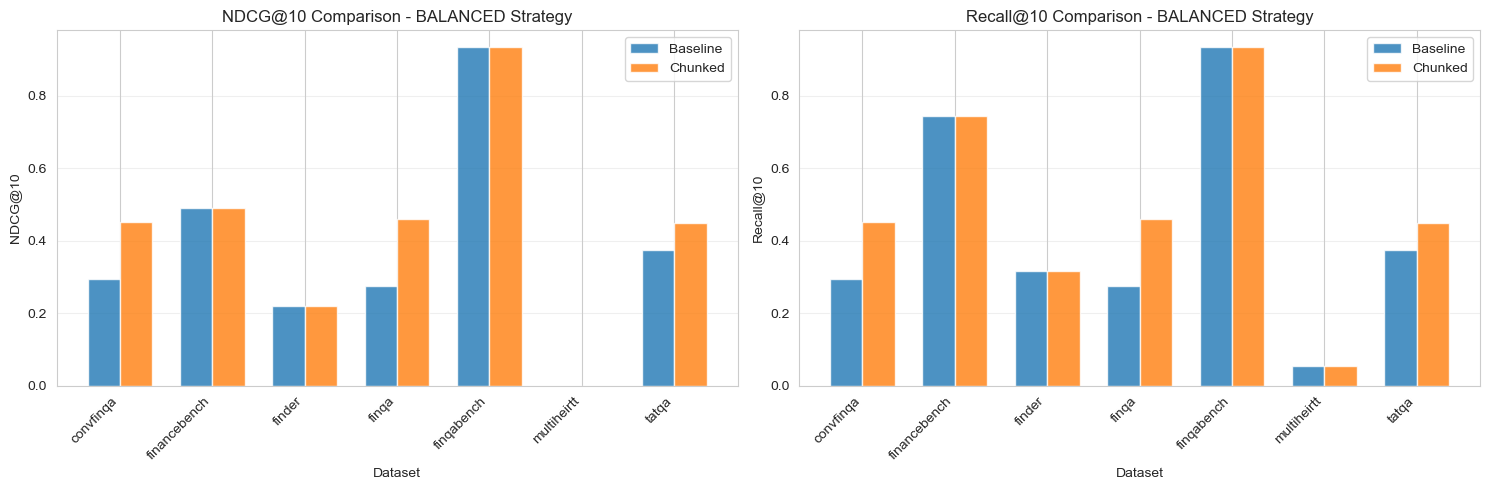

In [17]:
if CONFIG['evaluate_baseline']:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # NDCG Comparison
    ax1 = axes[0]
    x = np.arange(len(df_results))
    width = 0.35
    
    ax1.bar(x - width/2, df_results['baseline_ndcg'], width, label='Baseline', alpha=0.8)
    ax1.bar(x + width/2, df_results['chunked_ndcg'], width, label='Chunked', alpha=0.8)
    
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('NDCG@10')
    ax1.set_title(f'NDCG@10 Comparison - {CONFIG["strategy"].upper()} Strategy')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_results['dataset'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Recall Comparison
    ax2 = axes[1]
    ax2.bar(x - width/2, df_results['baseline_recall'], width, label='Baseline', alpha=0.8)
    ax2.bar(x + width/2, df_results['chunked_recall'], width, label='Chunked', alpha=0.8)
    
    ax2.set_xlabel('Dataset')
    ax2.set_ylabel('Recall@10')
    ax2.set_title(f'Recall@10 Comparison - {CONFIG["strategy"].upper()} Strategy')
    ax2.set_xticks(x)
    ax2.set_xticklabels(df_results['dataset'], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    fig_file = CONFIG['output_dir'] / f"comparison_{CONFIG['strategy']}.png"
    plt.savefig(fig_file, dpi=300, bbox_inches='tight')
    print(f"✓ Visualization saved to: {fig_file}")
    
    plt.show()
else:
    # Just plot chunked performance
    fig, ax = plt.subplots(figsize=(12, 5))
    
    x = np.arange(len(df_results))
    width = 0.35
    
    ax.bar(x - width/2, df_results['chunked_ndcg'], width, label='NDCG@10', alpha=0.8)
    ax.bar(x + width/2, df_results['chunked_recall'], width, label='Recall@10', alpha=0.8)
    
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Score')
    ax.set_title(f'Chunked Performance - {CONFIG["strategy"].upper()} Strategy')
    ax.set_xticks(x)
    ax.set_xticklabels(df_results['dataset'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    fig_file = CONFIG['output_dir'] / f"performance_{CONFIG['strategy']}.png"
    plt.savefig(fig_file, dpi=300, bbox_inches='tight')
    print(f"✓ Visualization saved to: {fig_file}")
    
    plt.show()

## 💾 Generate Submission File

In [18]:
# Create submission DataFrame
df_submission = pd.DataFrame(submission_data)

# Save submission file
submission_file = CONFIG['output_dir'] / CONFIG['submission_file']
df_submission.to_csv(submission_file, index=False)

print(f"\n✅ Submission file created: {submission_file}")
print(f"   Total queries: {len(df_submission)}")
print(f"\nFirst 5 rows:")
print(df_submission.head())


✅ Submission file created: output_chunking_eval\submission_chunked.csv
   Total queries: 4671

First 5 rows:
    query_id                                         corpus_ids
0  qd4982518  dd4bcfc62 dd4c0d2d8 dd4bbe0d4 dd4c4f7aa dd4c2f...
1  qd49795a8  dd4979602 dd4c4b0a6 dd4b9d0b4 dd4befb5c dd4bac...
2  qd496f724  dd4bcb2de dd4b9306e dd4c544d0 dd4c648e4 dd4bca...
3  qd496f102  dd4c043ae dd4bf30e0 dd4b90ada dd4c5e502 dd4bde...
4  qd496f918  dd4bbbab4 dd4c229ee dd4ba0908 dd4c60bae dd4baf...


## 📝 Generate Report

In [19]:
report = f"""
{'='*80}
CHUNKING EVALUATION REPORT
{'='*80}

Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

CONFIGURATION:
  Strategy: {CONFIG['strategy']}
  Chunking Method: {CHUNKING_CONFIG['method']}
  Chunk Size: {CHUNKING_CONFIG['chunk_size']}
  Chunk Overlap: {CHUNKING_CONFIG['overlap']}
  Model: {CONFIG['model_name']}
  Top-K: {CONFIG['top_k']}

DATASETS EVALUATED:
"""

for dataset in CONFIG['datasets']:
    report += f"  - {dataset}\n"

report += f"""
\nOVERALL RESULTS:
  Average Chunked NDCG@10: {df_results['chunked_ndcg'].mean():.4f}
  Average Chunked Recall@10: {df_results['chunked_recall'].mean():.4f}
  Average Expansion Factor: {df_results['expansion'].mean():.2f}x
"""

if CONFIG['evaluate_baseline']:
    report += f"""
\nBASELINE COMPARISON:
  Average Baseline NDCG@10: {df_results['baseline_ndcg'].mean():.4f}
  Average Baseline Recall@10: {df_results['baseline_recall'].mean():.4f}
  
  Average NDCG Improvement: {df_results['ndcg_improvement'].mean():+.2f}%
  Average Recall Improvement: {df_results['recall_improvement'].mean():+.2f}%
"""

report += f"""
\nPER-DATASET RESULTS:
"""

for _, row in df_results.iterrows():
    report += f"""
  {row['dataset'].upper()}:
    Docs: {row['num_docs']} → Chunks: {row['num_chunks']} (expansion: {row['expansion']:.2f}x)
    Chunked NDCG: {row['chunked_ndcg']:.4f} | Recall: {row['chunked_recall']:.4f}
"""
    if CONFIG['evaluate_baseline']:
        report += f"    Baseline NDCG: {row['baseline_ndcg']:.4f} | Recall: {row['baseline_recall']:.4f}\n"
        report += f"    Improvement: NDCG {row['ndcg_improvement']:+.2f}% | Recall {row['recall_improvement']:+.2f}%\n"

report += f"""
\nOUTPUT FILES:
  Results: {results_file}
  Submission: {submission_file}
  Chunked Corpora: {CONFIG['output_dir']}/*_corpus_chunked.jsonl

{'='*80}
"""

print(report)

# Save report
report_file = CONFIG['output_dir'] / f"evaluation_report_{CONFIG['strategy']}.txt"
with open(report_file, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"\n✓ Report saved to: {report_file}")


CHUNKING EVALUATION REPORT

Date: 2025-12-28 15:57:37

CONFIGURATION:
  Strategy: balanced
  Chunking Method: character
  Chunk Size: 1500
  Chunk Overlap: 300
  Model: sentence-transformers/all-MiniLM-L6-v2
  Top-K: 10

DATASETS EVALUATED:
  - convfinqa
  - financebench
  - finder
  - finqa
  - finqabench
  - multiheirtt
  - tatqa


OVERALL RESULTS:
  Average Chunked NDCG@10: 0.4286
  Average Chunked Recall@10: 0.4869
  Average Expansion Factor: 1.54x


BASELINE COMPARISON:
  Average Baseline NDCG@10: 0.3692
  Average Baseline Recall@10: 0.4275

  Average NDCG Improvement: +23.38%
  Average Recall Improvement: +20.04%


PER-DATASET RESULTS:

  CONVFINQA:
    Docs: 2066 → Chunks: 4992 (expansion: 2.42x)
    Chunked NDCG: 0.4524 | Recall: 0.4524
    Baseline NDCG: 0.2937 | Recall: 0.2937
    Improvement: NDCG +54.05% | Recall +54.05%

  FINANCEBENCH:
    Docs: 180 → Chunks: 221 (expansion: 1.23x)
    Chunked NDCG: 0.4889 | Recall: 0.7444
    Baseline NDCG: 0.4889 | Recall: 0.7444
    I

## 🎯 Next Steps

### ✅ What you've achieved:
1. Applied optimal chunking strategy to all 7 datasets
2. Compared performance: chunked vs non-chunked
3. Generated submission file with chunked retrieval
4. Created visualizations and detailed report

### 🔄 To try different strategies:
1. Change `CONFIG['strategy']` to: `'max_performance'`, `'memory_efficient'`, or `'high_precision'`
2. Re-run cells from "Main Evaluation Loop" onwards
3. Compare results across strategies

### 🚀 For production deployment:
1. Use the generated chunked corpus files (`.jsonl`)
2. Integrate `OptimizedChunkedRetriever` from chunking_notebook
3. Add reranking stage for further improvement
4. Monitor performance on validation set

### 🔬 Further optimizations:
- Combine with BM25 for hybrid retrieval
- Add reranking (cross-encoder)
- Try different embedding models
- Experiment with query expansion
- Fine-tune aggregation strategy (max vs mean vs sum)